## TabNet Implentation for Tabular Data

TabNet is proposed in [this article] (https://arxiv.org/abs/1908.07442) as a neural network architecture capable of learning a canonical representation of tabular data. This architecture has shown to perform well against the current gold-standard gradient boosting models for learning on tabular data.

TabNet uses a sequential attention mechanism to choose a subset of semantically meaningful
features to process at each decision step. Instance-wise feature selection enables efficient learning as the model capacity is fully used for the most salient features, and also yields
more interpretable decision making via visualization of selection masks. 


This implementation closely follows [the TabNet implementation in PyTorch linked here](https://github.com/dreamquark-ai/tabnet/tree/b6e1ebaf694f37ad40a6ba525aa016fd3cec15da). 

<img src="images/tabnet_schematic2.jpg" width="1000" height="800" align="center"/>


#### GLU Block

Gated Linear Units act as an attention mechanism where the gates formed involve taking two dense layer outputs, applying a sigmoid to one of them, and then multiplying them together

Following GLU blcok contains two dense layers, two ghost batch normalization layers, identity and sigmoid activation functions and multiplication operation.


### Feature Transformer Block

Builds two GLU blocks with a skip connection from the output of the first

<img src="images/tabnet_feature_transformer.jpg" width="700" height="500" align="center"/>

#### Attentive Transformer Block

Use TabNet prior as an input to layer and reserve to handle prior updates in TabNet step layer

> *prior is used to encourage orthogonal feature selection across decision steps, tell us what we know about features and how we have used them in the previous step

<img src="images/tabnet_attentive_transformer.jpg" width="200" height="200" align="center"/>

In [ ]:
# ! pip install pytorch-tabnet

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import global_variables as gv
import utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score

from pytorch_tabnet.tab_model import TabNetClassifier

In [2]:
df = pd.read_csv(gv.data_link)
pd.set_option('display.max_columns', None)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,30850-0.0,30780-0.0,30690-0.0,30790-0.0,23101-0.0,23099-0.0,48-0.0,23100-0.0,30710-0.0,30760-0.0,30640-0.0,30750-0.0,49-0.0,30770-0.0,30740-0.0,30630-0.0,30870-0.0,21001-0.0,1488-0.0,4079-0.0,1299-0.0,21003-0.0,1160-0.0,1438-0.0,4080-0.0,1458-0.0,1528-0.0,1319-0.0,845-0.0,1289-0.0,1309-0.0,1418-0.0,1329-0.0,1220-0.0,1428-0.0,1249-0.0,1349-0.0,1369-0.0,20117-0.0,2100-0.0,2654-0.0,1339-0.0,21000-0.0,2050-0.0,1408-0.0,1200-0.0,1538-0.0,31-0.0,6138-0.0,1359-0.0,1389-0.0,1478-0.0,2090-0.0,1508-0.0,1379-0.0,6142-0.0,1468-0.0,1548-0.0,1239-0.0,1448-0.0,hypertension,outcome_cardiomyopathies,outcome_ischemic_heart_disease,outcome_heart_failure,outcome_myocardial_infarction,outcome_peripheral_vascular_disease,outcome_cardiac_arrest,outcome_cerebral_infarction,outcome_arrhythmia,multi-labels,age,gender,race
0,0.50800,3.88800,6.47700,65.1984,45.2,35.6,74.0,25.0,0.34,1.70600,1.21100,35.065,102.0,26.339,5.62200,1.59300,0.97700,24.5790,6.0,77.0,10.0,54.0,7.0,10.0,110.0,3.73,2.0,0.0,23.52,6.0,2.0,3,2,0,0,1,1,1,2,1,6,2,0,2,1,3,2,0,1,2,1,1,1,3,1,1,3,2,0,3,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 1]",54,Female,British
1,13.08800,3.52000,5.51200,15.4000,74.6,36.5,120.0,42.9,3.94,1.17300,1.01900,40.900,113.0,10.701,5.05200,1.39000,2.35800,35.0861,2.0,91.0,2.0,65.0,9.0,12.0,166.0,7.00,2.4,0.0,16.00,2.0,1.0,2,2,0,1,1,4,2,2,0,7,2,0,1,3,2,0,1,3,3,1,1,0,2,2,1,5,2,0,1,1,0,1,0,1,0,0,0,0,"[1, 0, 1, 0, 0, 0, 0, 0]",65,Male,British
2,9.73364,4.10892,6.47949,50.8588,71.7,29.7,112.0,30.3,3.88,1.58546,1.22432,84.100,107.0,18.763,13.71763,1.74423,2.78764,30.7934,0.0,99.0,2.0,55.0,7.0,10.0,135.0,7.00,2.0,0.0,21.00,3.0,1.0,2,1,0,0,1,2,1,2,0,7,2,0,1,2,2,1,1,3,3,2,1,0,2,2,1,4,2,0,3,1,0,1,0,0,0,1,1,1,"[0, 0, 1, 0, 0, 1, 1, 1]",55,Male,British
3,1.78800,2.88700,5.56500,56.5183,40.2,29.8,67.0,17.0,0.87,2.11500,0.81000,36.400,91.0,31.672,4.82700,1.89100,1.15700,20.7577,0.0,71.0,5.0,49.0,8.0,14.0,116.0,5.00,3.0,1.0,18.00,5.0,1.0,2,2,0,0,4,1,2,2,0,7,2,2,1,2,1,2,0,6,2,2,1,0,2,2,1,3,2,0,3,0,0,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 1]",49,Female,Irish
4,0.75600,2.67000,4.68000,4.7700,46.5,30.1,85.0,20.0,0.18,1.49300,0.73300,34.200,105.0,42.209,5.06300,1.86900,1.67700,25.9766,7.0,73.0,4.0,61.0,7.0,2.0,113.0,7.00,4.0,2.0,16.00,3.0,3.0,3,2,1,1,4,1,1,2,0,7,3,0,1,3,1,0,0,3,3,1,2,0,1,1,1,4,2,0,3,1,0,0,0,1,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0]",61,Female,British


### Test TabNet Binary Classifier out-of-the-box (predicting Ischemic Heart Disease)

In [23]:
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1 = utilities.process_features(df, gv.outcomes[2], StandardScaler(), one_hot=True)
X_train1, y_train1= utilities.resample_data(X_train1, y_train1, 'under')

X_train= X_train1.to_numpy()
X_val= X_val1.to_numpy()
X_test= X_test1.to_numpy()

y_train= y_train1.to_numpy()
y_val= y_val1.to_numpy()
y_test= y_test1.to_numpy()

In [7]:
from pytorch_tabnet.metrics import Metric
from keras import backend as K
class my_recall(Metric):
    def __init__(self):
        self._name = "recall"
        self._maximize = True

    def __call__(self, y_true, y_score):
        return recall_score(y_true, y_score[:,1])

In [9]:
clf = TabNetClassifier()  


clf.fit(X_train, y_train,
  eval_set=[(X_val, y_val)],
  eval_metric=["auc"]
)

preds = clf.predict(X_test)

Device used : cpu
epoch 0  | loss: 0.70599 | val_0_auc: 0.59174 |  0:00:03s
epoch 1  | loss: 0.67856 | val_0_auc: 0.60514 |  0:00:07s
epoch 2  | loss: 0.67074 | val_0_auc: 0.63598 |  0:00:11s
epoch 3  | loss: 0.6608  | val_0_auc: 0.65745 |  0:00:15s
epoch 4  | loss: 0.65713 | val_0_auc: 0.66567 |  0:00:20s
epoch 5  | loss: 0.65427 | val_0_auc: 0.66975 |  0:00:24s
epoch 6  | loss: 0.65039 | val_0_auc: 0.67362 |  0:00:29s
epoch 7  | loss: 0.64773 | val_0_auc: 0.67414 |  0:00:33s
epoch 8  | loss: 0.64835 | val_0_auc: 0.67648 |  0:00:37s
epoch 9  | loss: 0.64655 | val_0_auc: 0.6827  |  0:00:41s
epoch 10 | loss: 0.64215 | val_0_auc: 0.68757 |  0:00:45s
epoch 11 | loss: 0.63986 | val_0_auc: 0.69226 |  0:00:49s
epoch 12 | loss: 0.63758 | val_0_auc: 0.69549 |  0:00:53s
epoch 13 | loss: 0.63491 | val_0_auc: 0.69701 |  0:00:57s
epoch 14 | loss: 0.63313 | val_0_auc: 0.69772 |  0:01:01s
epoch 15 | loss: 0.63194 | val_0_auc: 0.69824 |  0:01:05s
epoch 16 | loss: 0.631   | val_0_auc: 0.70142 |  0:01:

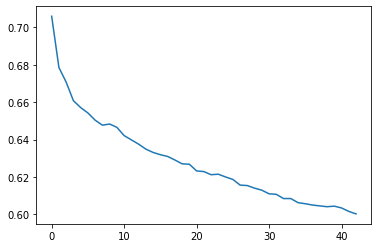

In [13]:
# plot losses
plt.plot(clf.history['loss'])

### Global Explainability

In [33]:
feat_weights = clf.feature_importances_

# zip to feature names
input_cols = X_train1.columns.to_list()
feat_dict = dict(zip(input_cols, feat_weights))

### Local Explainablity

In [17]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
test_auc

0.7109673743008749

## Customize Model Parameters

#### Fit parameters

<ul>
  <li> <b>X_train</b> (np.array): Training Features </li>
  <li> <b>y_train</b> (np.array): Training Targets </li>
  <li> <b>eval_set</b> (list of eval tuple set):  last one used for early stopping </li>
  <li> <b>eval_name</b> (list of str): list of eval set names </li>
  <li> <b>eval_metric</b> (list of str: list of evaluation metrics; last used for early stopping </li>
  <li> <b>max_epochs</b> (int=200): max epochs for training</li>
  <li> <b>patience</b> (int=10):#epochs before early stopping, if 0 then no early stopping performed </li>
  <li> <b>weights</b> (int or dict=0): only for TabNetClassifier, sampling param 0 => no sampling, param 0 => automated sampling with inverse class occurences </li>
  <li> <b>loss_fn</b>(torch.loss): loss fn for training, w classification can set a list of same length as num tasks  </li>
  <li> <b>batch_size</b> (int=1024): #  examples/batch </li>
  <li> <b>virtual_batch_size</b> (int=128): size of mini batches for ghost batch normalization  </li>
  <li> <b>num_workers</b> (int=0): # workers used in torch.utils.data.Dataloader  </li>
  <li> <b>drop_last</b> (bool=False): whether to drop last batch if not complete during training  </li>
  <li> <b>callbacks</b> (list of callback fn): list of custom callbacks </li>
  <li> <b>pretraining_ratio</b> (float): %input features to mask during pretraining  </li>
  <li> <b>warm_start</b> (bool=False): allows to fit twice the same model and start from a warm start  </li>

</ul>

In [ ]:
METRICS = [utilities.recall_m]

In [ ]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerat

In [ ]:
tabnet_params = {"cat_idxs":cat_idxs, # list of categorical feature indices
                 "cat_dims":cat_dims, # list of categorical features number of modalities (#unique values for a categorical feature)
                 "cat_emb_dim":1, # list of embeddings size for each categorical features
                 "optimizer_fn":torch.optim.Adam, # pytorch optimizer function
                 "optimizer_params":dict(lr=2e-2), # parameters compatible with optimizer_fn
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9}, # dictionary of parameters to apply to the scheduler
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax" # either sparsemax or entmac, masking fn for selecting features
                }


In [ ]:
# BCELoss()

### Implement Semi-supervised Pre-training (tbd)

In [ ]:
# import preprocessed data before imputation
df2 = pd.read_csv(gv.tabnet_data)
df2.drop('Unnamed: 0', axis=1, inplace=True)
df2.head()

In [ ]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_val],
    pretraining_ratio=0.8,
)

clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax' # This will be overwritten if using pretrain model
)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    from_unsupervised=unsupervised_model
)

### Save & Load TabNet Classifier

In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)